In [1]:
import sys 
sys.path.append("../src/")
import models

In [2]:
import torch
audio_model_wa = models.CAVMAEFT(label_dim=13, modality_specific_depth=11)
exp_dir = "/home/artmed/PycharmProjects/cav-mae/zzh_code/exp/testmae01-full-cav-mae-ft-1e-5-5-0.95-1-bs128-ldaFalse-multimodal-fzFalse-h50-r3"
def wa_model(exp_dir, start_epoch, end_epoch):
    sdA = torch.load(exp_dir + '/models/audio_model.' + str(start_epoch) + '.pth', map_location='cpu')
    model_cnt = 1
    for epoch in range(start_epoch+1, end_epoch+1):
        sdB = torch.load(exp_dir + '/models/audio_model.' + str(epoch) + '.pth', map_location='cpu')
        for key in sdA:
            sdA[key] = sdA[key] + sdB[key]
        model_cnt += 1
    print('wa {:d} models from {:d} to {:d}'.format(model_cnt, start_epoch, end_epoch))
    for key in sdA:
        sdA[key] = sdA[key] / float(model_cnt)
    return sdA

audio_model_wa = torch.nn.DataParallel(audio_model_wa)
sdA = wa_model(exp_dir, start_epoch=1, end_epoch=100)
msg = audio_model_wa.load_state_dict(sdA, strict=True)
print(msg)
audio_model_wa.eval()

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
wa 100 models from 1 to 100
<All keys matched successfully>


DataParallel(
  (module): CAVMAEFT(
    (patch_embed_a): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (patch_embed_v): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks_a): ModuleList(
      (0-10): 11 x Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm1_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm1_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2_v):

In [3]:
import torch
audio_model = models.CAVMAEFT(label_dim=13, modality_specific_depth=11)
exp_dir = "/home/artmed/PycharmProjects/cav-mae/zzh_code/exp/testmae01-full-cav-mae-ft-1e-5-5-0.95-1-bs128-ldaFalse-multimodal-fzFalse-h50-r3"
audio_model = torch.nn.DataParallel(audio_model)
sdA = torch.load(exp_dir + '/models/best_audio_model.pth', map_location='cpu')
msg = audio_model.load_state_dict(sdA, strict=True)
print(msg)
audio_model.eval()

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
<All keys matched successfully>


DataParallel(
  (module): CAVMAEFT(
    (patch_embed_a): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (patch_embed_v): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks_a): ModuleList(
      (0-10): 11 x Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm1_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm1_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2_v):

In [4]:
import dataloader as dataloader
im_res = 224
val_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': "audioset",
                  'mode':'eval', 'mean': -5.081, 'std': 4.4849, 'noise': False, 'im_res': im_res}

data_val = "/home/artmed/PycharmProjects/cav-mae/zzh_code/FOS_validation_dataset.json"
label_csv="/home/artmed/PycharmProjects/cav-mae/zzh_code/FOS_used_label.csv"
num_workers = 32


In [5]:
sys.path.append("../src/")
from utilities import *
import torch
from torch import nn
import numpy as np
import pickle
import time
from torch.cuda.amp import autocast,GradScaler

In [6]:
def validate(audio_model, val_loader, loss_fn, output_pred=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_time = AverageMeter()
    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)
    audio_model = audio_model.to(device)
    audio_model.eval()

    end = time.time()
    A_predictions, A_targets, A_loss = [], [], []
    with torch.no_grad():
        for i, (a_input, v_input, labels) in enumerate(val_loader):
            a_input = a_input.to(device)
            v_input = v_input.to(device)

            with autocast():
                audio_output = audio_model(a_input, v_input, 'multimodal')

            predictions = audio_output.to('cpu').detach()

            A_predictions.append(predictions)
            A_targets.append(labels)

            labels = labels.to(device)
            loss = loss_fn(audio_output, labels)
            A_loss.append(loss.to('cpu').detach())

            batch_time.update(time.time() - end)
            end = time.time()

        audio_output = torch.cat(A_predictions)
        target = torch.cat(A_targets)
        loss = np.mean(A_loss)

        stats = calculate_stats(audio_output, target)

    if output_pred == False:
        return stats, loss
    else:
        # used for multi-frame evaluation (i.e., ensemble over frames), so return prediction and target
        return stats, audio_output, target

In [8]:
# Find the best mAP frame
res = []
multiframe_pred = []
total_frames = 10
best_mAP = 0
loss_fn = nn.BCEWithLogitsLoss()
for frame in range(total_frames):
    val_audio_conf['frame_use'] = frame
    val_loader = torch.utils.data.DataLoader(
        dataloader.AudiosetDataset(data_val, label_csv=label_csv, audio_conf=val_audio_conf),
        batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True)
    stats, audio_output, target = validate(audio_model, val_loader, loss_fn, output_pred=True)
    print(audio_output.shape)

    audio_output = torch.nn.functional.sigmoid(audio_output.float())

    audio_output, target = audio_output.numpy(), target.numpy()
    multiframe_pred.append(audio_output)
    cur_res = np.mean([stat['AP'] for stat in stats])
    if cur_res > best_mAP:
        best_mAP = cur_res
        print("Here is the best!!!!!!!!!!!!!!!!!!!!!!!!")
    print('mAP of frame {:d} is {:.4f}'.format(frame, cur_res))

    res.append(cur_res)

Dataset has 1611 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -5.081 and std 4.485 to normalize the input.
not use noise augmentation
number of classes is 13
now in eval mode.
now use frame 0 from total 10 frames
now using 224 * 224 image input
torch.Size([1611, 13])
Here is the best!!!!!!!!!!!!!!!!!!!!!!!!
mAP of frame 0 is 0.5022
Dataset has 1611 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -5.081 and std 4.485 to normalize the input.
not use noise augmentation
number of classes is 13
now in eval mode.
now use frame 1 from total 10 frames
now using 224 * 224 image input
torch.Size([1611, 13])
Here is the best!!!!!!!!!!!!!!!!!!!!!!!!
mAP of frame 1 is 0.5026
Dataset has 1611 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.

In [7]:
loss_fn = nn.BCEWithLogitsLoss()
val_audio_conf['frame_use'] = 5
val_loader = torch.utils.data.DataLoader(
        dataloader.AudiosetDataset(data_val, label_csv=label_csv, audio_conf=val_audio_conf),
        batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_time = AverageMeter()
audio_model = audio_model.to(device)
audio_model.eval()

end = time.time()
A_predictions, A_targets, A_loss = [], [], []
with torch.no_grad():
        for i, (a_input, v_input, labels) in enumerate(val_loader):
                a_input = a_input.to(device)
                v_input = v_input.to(device)

                with autocast():
                        audio_output = audio_model(a_input, v_input, 'multimodal')

                predictions = audio_output.to('cpu').detach()

                A_predictions.append(predictions)
                A_targets.append(labels)

                labels = labels.to(device)
                loss = loss_fn(audio_output, labels)
                A_loss.append(loss.to('cpu').detach())

                batch_time.update(time.time() - end)
                end = time.time()

audio_output = torch.cat(A_predictions)
target = torch.cat(A_targets)
loss = np.mean(A_loss)

stats = calculate_stats(audio_output, target)

Dataset has 1611 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -5.081 and std 4.485 to normalize the input.
not use noise augmentation
number of classes is 13
now in eval mode.
now use frame 5 from total 10 frames
now using 224 * 224 image input


In [93]:
# Calculate the global statics
import pandas as pd
from sklearn import metrics
df_used_labels = pd.read_csv("/home/artmed/PycharmProjects/cav-mae/zzh_code/FOS_used_label.csv")
predictions = torch.nn.functional.sigmoid(audio_output.float())
# predictions = audio_output
threshold = 0.5
labels = target

f1_score = metrics.f1_score(labels, predictions > threshold, average='micro')
accuracy = torch.sum((predictions > threshold) == labels) / (labels.shape[0] * labels.shape[1])
strict_accuracy = metrics.accuracy_score(labels, predictions > threshold)
auc = metrics.roc_auc_score(labels, predictions, average='micro')
mAP = metrics.average_precision_score(labels, predictions, average='micro')

print("The global statics of the model are:")
print('F1 score: {:.4f}'.format(f1_score))
print('Accuracy: {:.4f}'.format(accuracy))
print('Strict accuracy: {:.4f}'.format(strict_accuracy))
print('AUC: {:.4f}'.format(auc))
print('mAP: {:.4f}'.format(mAP))


The global statics of the model are:
F1 score: 0.7068
Accuracy: 0.8921
Strict accuracy: 0.3222
AUC: 0.9342
mAP: 0.8054


In [64]:
# Calculate the AUC and ACC for each class
import pandas as pd
from sklearn import metrics
df_used_labels = pd.read_csv("/home/artmed/PycharmProjects/cav-mae/zzh_code/FOS_used_label.csv")
# predictions = torch.nn.functional.sigmoid(audio_output.float())
predictions = audio_output
labels = target
threshold = 0.5
avg_precisions = []
f1_scores = []
accs = []
for cls in range(audio_output.shape[1]):
    name_label = df_used_labels.iloc[cls]['display_name']
    cls_predictions = predictions[:, cls].numpy()
    cls_labels = labels[:, cls].numpy()

    auc = metrics.roc_auc_score(cls_labels, cls_predictions)
    avg_precision = metrics.average_precision_score(cls_labels, cls_predictions)
    f1_score = metrics.f1_score(cls_labels, cls_predictions > threshold)
    acc = metrics.accuracy_score(cls_labels, cls_predictions > threshold)


    avg_precisions.append(avg_precision)
    f1_scores.append(f1_score)
    accs.append(acc)


Average precision of all classes (mAP) is 0.5070
F1 score of all classes is 0.4003
The final accuracy is 0.8921


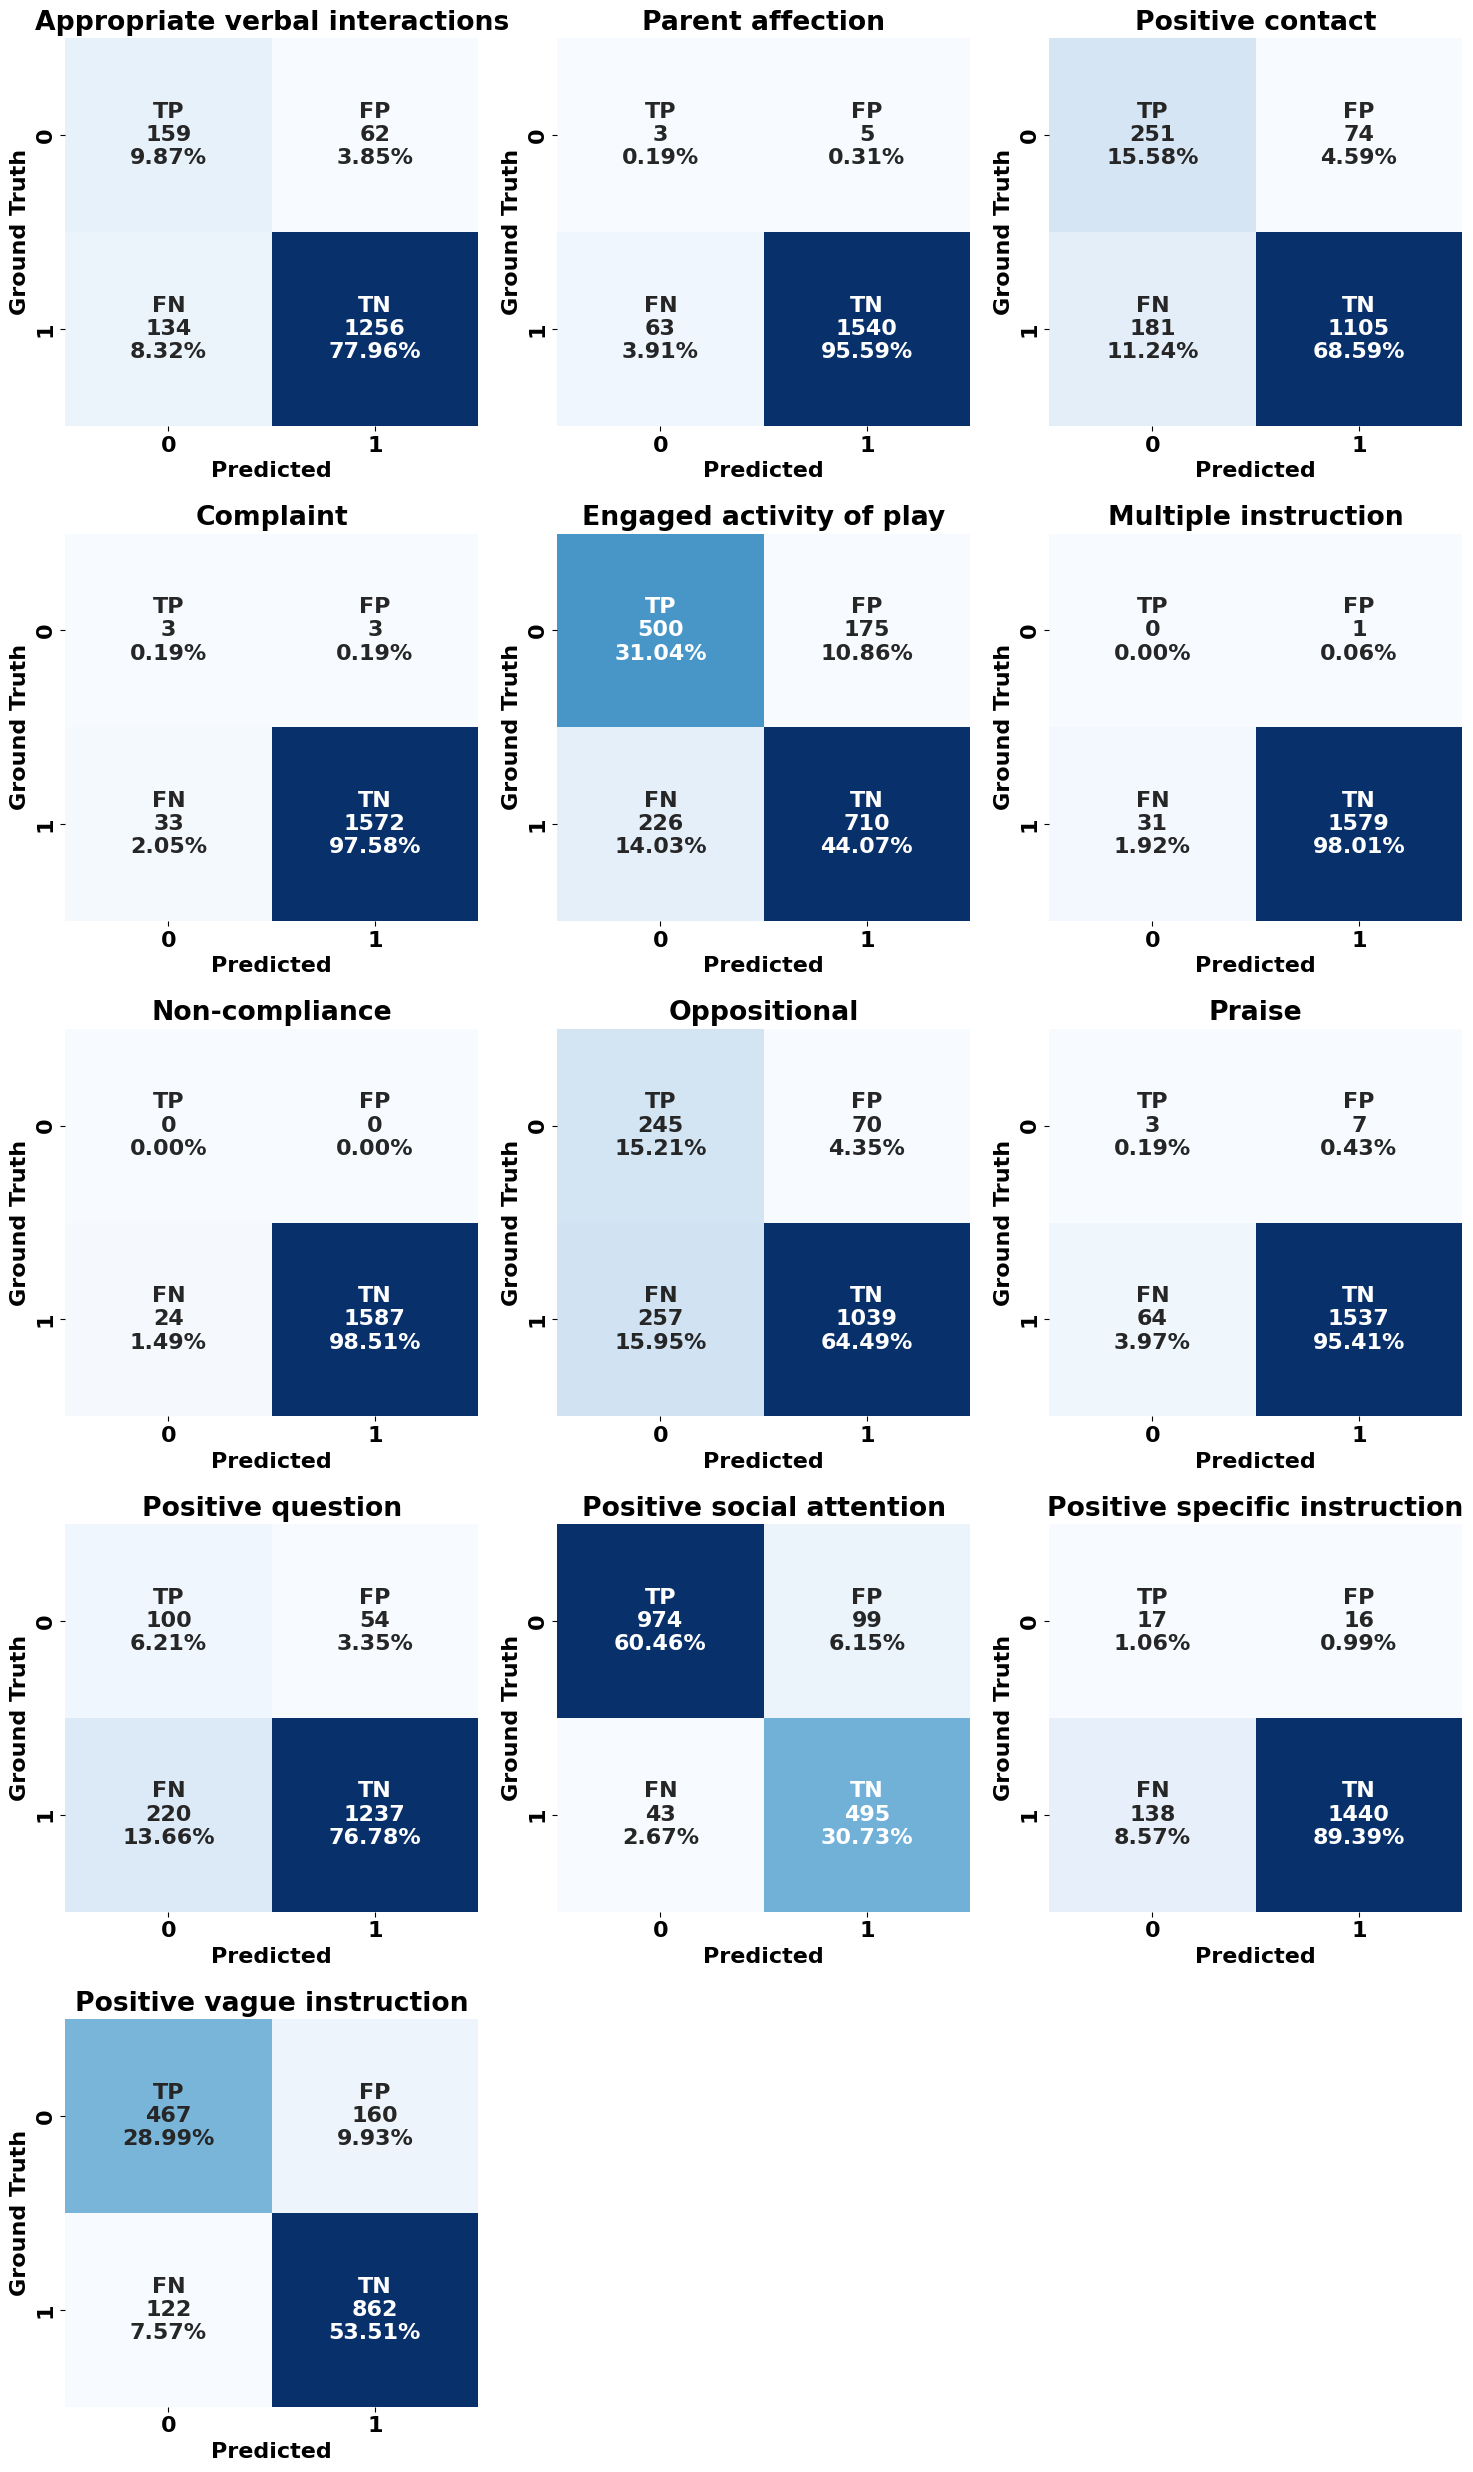

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 25))
# Change the font size of the labels
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'font.weight': 'bold'})
# Calculate the confusion matrix for each class
for cls in range(audio_output.shape[1]):
    name_label = df_used_labels.iloc[cls]['display_name']
    predictions = nn.functional.sigmoid(audio_output[:, cls]).numpy()
    # predictions = audio_output[:, cls].numpy()
    labels = target[:, cls].numpy()

    # Calculate the confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(labels, predictions > threshold).ravel()
    conf_matrix = np.array([[tp, fp], [fn, tn]])

    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.subplot(5, 3, cls+1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={'weight': 'bold'})
    plt.title(name_label, weight='bold')
    plt.xlabel('Predicted', weight='bold')
    plt.ylabel('Ground Truth', weight='bold')
    
plt.tight_layout()
plt.savefig('/home/artmed/PycharmProjects/cav-mae/zzh_code/confusion_matrix_04_11.png', dpi=300, bbox_inches='tight')
# plt.show()
# Reset the font size of the labels
plt.rcdefaults()

In [18]:
conf_matrix

array([[382,  99],
       [207, 923]])

In [17]:
predictions > threshold

tensor([False,  True,  True,  ..., False, False, False])

In [12]:
cls

12